CSF Biomarker Baseline Pipeline


In [1]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    _HAS_SNS = True
    sns.set_context("notebook")
except Exception:
    _HAS_SNS = False

#  plotting
%matplotlib inline
SHOW_PLOTS = True

# Visit priority
VISIT_PRIORITY = {
    "bl": 1, "init": 1,
    "sc": 2, "screening": 2,
    "m03": 3, "month3": 3, "3m": 3,
    "m06": 4, "month6": 4, "6m": 4,
    "m12": 5, "month12": 5, "12m": 5,
    "m24": 6, "month24": 6,
}

# Normalize column names 
def normalize_colnames(cols):
    out = []
    for c in cols:
        c2 = str(c).strip()
        c2 = c2.replace("\n"," ")
        out.append(c2)
    return out

PTID_TOKENS  = ["ptid", "rid", "subject", "participant", "id"]
VISIT_TOKENS = ["visit", "viscode", "vis", "examdate", "exam"]

# column matcher 
def _canon(s: str) -> str:
    s = s.lower()
    s = s.replace("β", "beta").replace("ß", "beta")
    s = re.sub(r"[^a-z0-9]+", "_", s)
    s = re.sub(r"_+", "_", s).strip("_")
    return s

def find_contains_col(df, token_list):
    canon_cols = { _canon(c): c for c in df.columns }
    tokens_c = [_canon(t) for t in token_list]
    
    for tc in tokens_c:
        if tc in canon_cols:
            return canon_cols[tc]
    
    for canon_c, orig_c in canon_cols.items():
        for tc in tokens_c:
            if tc in canon_c or canon_c.startswith(tc) or canon_c.endswith(tc):
                return orig_c
    return None

# Expanded CSF token lists
TAU_TOKENS      = ["tau", "total tau", "t_tau", "ttau", "tau_pg_ml", "tau_pgml", "tau_pg_ml_", "tau_pg_ml__"]
PTAU_TOKENS     = ["ptau", "p_tau", "phospho tau", "phospho_tau", "p_tau_pg_ml", "ptau_pg_ml"]
ABETA42_TOKENS  = ["abeta42", "a_beta_42", "a_beta42", "ab42", "a42", "amyloid_beta_42", "abeta_1_42", "aβ42", "aß42"]
ABETA40_TOKENS  = ["abeta40", "a_beta_40", "a_beta40", "ab40", "a40", "amyloid_beta_40", "abeta_1_40", "aβ40", "aß40"]

# to find exact-like columns
def find_exact_col(df, token_list):
    lcmap = {str(c).lower(): c for c in df.columns}
    for tok in token_list:
        if tok in lcmap:
            return lcmap[tok]
    
    return find_contains_col(df, token_list)

# Visit priority parser
def parse_visit_priority(val):
    if pd.isna(val):
        return 999
    v = str(val).strip().lower()
    if v in VISIT_PRIORITY:
        return VISIT_PRIORITY[v]
    # handle things like "m18", "m36"
    if v.startswith('m') and v[1:].isdigit():
        return 100 + int(v[1:])
    return 999


In [2]:
# Paths 
PROJECT_ROOT = Path("/Users/madhurabn/Desktop/adni")  
input_path   = PROJECT_ROOT / "data" / "raw" / "CSF biomarkers ADNI.xlsx"
outdir       = PROJECT_ROOT / "data" / "processed"
plots_dir    = outdir / "plots" / "csf"

outdir.mkdir(parents=True, exist_ok=True)
plots_dir.mkdir(parents=True, exist_ok=True)
print("Paths set:\n- input:", input_path, "\n- out:", outdir, "\n- plots:", plots_dir)


Paths set:
- input: /Users/madhurabn/Desktop/adni/data/raw/CSF biomarkers ADNI.xlsx 
- out: /Users/madhurabn/Desktop/adni/data/processed 
- plots: /Users/madhurabn/Desktop/adni/data/processed/plots/csf


In [3]:
# Load, baseline-filter (one row per PTID)
xl = pd.ExcelFile(input_path)
df = xl.parse(xl.sheet_names[0])
df.columns = normalize_colnames(df.columns)

ptid_col  = find_exact_col(df, PTID_TOKENS)
visit_col = find_exact_col(df, VISIT_TOKENS)
if ptid_col is None or visit_col is None:
    raise ValueError(f"Required columns not found. PTID={ptid_col}, VISIT={visit_col}\nGot: {list(df.columns)}")

# gender/age 
gender_col = find_contains_col(df, ["gender", "sex"]) 
age_col    = find_contains_col(df, ["entry_age", "age", "ptage", "baselineage"]) 

# apply visit priority to keep earliest visit per PTID
work = df.copy()
work["_visit_priority"] = work[visit_col].apply(parse_visit_priority)
work_sorted = work.sort_values(by=["_visit_priority"]).copy()
baseline = work_sorted.drop_duplicates(subset=[ptid_col], keep="first").copy()
baseline.drop(columns=["_visit_priority"], inplace=True)

print("Baseline shape (one row per PTID):", baseline.shape)


Baseline shape (one row per PTID): (749, 7)


In [4]:
# Detect CSF columns and compute ratios 

def find_col(df, tokens):
    return find_contains_col(df, tokens)

col_tau   = find_col(baseline, TAU_TOKENS)
col_ptau  = find_col(baseline, PTAU_TOKENS)
col_ab42  = find_col(baseline, ABETA42_TOKENS)

print("Detected CSF biomarker columns:\n - Total Tau:", col_tau, "\n - p-Tau:", col_ptau, "\n - Aβ42:", col_ab42)

# ratios
if col_tau is not None and col_ab42 is not None:
    baseline["Tau_over_Abeta42"] = pd.to_numeric(baseline[col_tau], errors="coerce") / pd.to_numeric(baseline[col_ab42], errors="coerce")
if col_ptau is not None and col_ab42 is not None:
    baseline["pTau_over_Abeta42"] = pd.to_numeric(baseline[col_ptau], errors="coerce") / pd.to_numeric(baseline[col_ab42], errors="coerce")



# save baseline with ratios
baseline_xlsx = outdir / "csf_baseline.xlsx"
baseline.to_excel(baseline_xlsx, index=False)
print("Saved baseline with ratios ->", baseline_xlsx)


Detected CSF biomarker columns:
 - Total Tau: TAU 
 - p-Tau: PTAU 
 - Aβ42: ABETA42
Saved baseline with ratios -> /Users/madhurabn/Desktop/adni/data/processed/csf_baseline.xlsx


In [5]:
# DEBUG: show detection results
print("Columns (first 20):", list(baseline.columns)[:20])
print("Total columns:", len(baseline.columns))
print({
    "TAU": col_tau,
    "pTAU": col_ptau,
    "AB42": col_ab42,
    
})


Columns (first 20): ['PTID', 'RID', 'visit', 'ABETA40', 'ABETA42', 'TAU', 'PTAU', 'Tau_over_Abeta42', 'pTau_over_Abeta42']
Total columns: 9
{'TAU': 'TAU', 'pTAU': 'PTAU', 'AB42': 'ABETA42'}


In [6]:
# Quick summary after baseline and computed ratios
print("\n CSF Baseline Summary (after ratios) ")

# Drop Abeta40 if present because it is too sparse 
for _c in [c for c in baseline.columns if "abeta40" in c.lower() or "abeta42_over_abeta40" in c.lower()]:
    baseline.drop(columns=[_c], inplace=True)
    print("Dropped:", _c)

print("Shape:", baseline.shape)

# overall missingness
total_missing = int(baseline.isna().sum().sum())
print("Total missing cells:", total_missing)

# top missing columns
miss_per_col = baseline.isna().sum().sort_values(ascending=False)
print("\nTop missing columns (first 15):")
print(miss_per_col.head(15))

# basic describe for numeric columns
print("\nNumeric describe():")
print(baseline.select_dtypes(include=[np.number]).describe().T)



 CSF Baseline Summary (after ratios) 
Dropped: ABETA40
Shape: (749, 8)
Total missing cells: 15

Top missing columns (first 15):
Tau_over_Abeta42     4
pTau_over_Abeta42    4
TAU                  3
PTAU                 3
ABETA42              1
PTID                 0
RID                  0
visit                0
dtype: int64

Numeric describe():
                   count         mean          std         min          25%  \
RID                749.0  3795.393858  2206.194065    3.000000  1281.000000   
ABETA42            748.0   797.055348   447.076638  210.900000   511.675000   
TAU                746.0   316.608029   132.521042   88.690000   220.600000   
PTAU               746.0    31.297989    15.105380    8.530000    20.202500   
Tau_over_Abeta42   745.0     0.499996     0.305264    0.076269     0.274658   
pTau_over_Abeta42  745.0     0.050062     0.033620    0.006382     0.025179   

                           50%          75%          max  
RID                4514.000000  5198.000

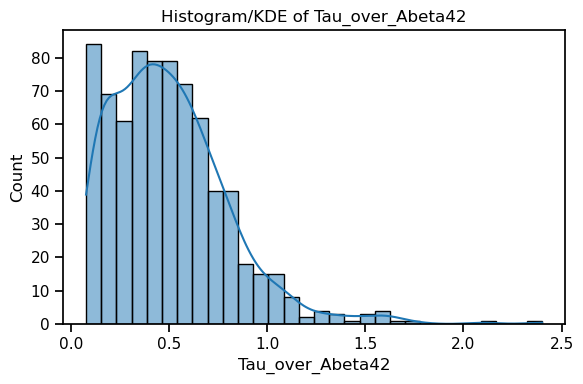

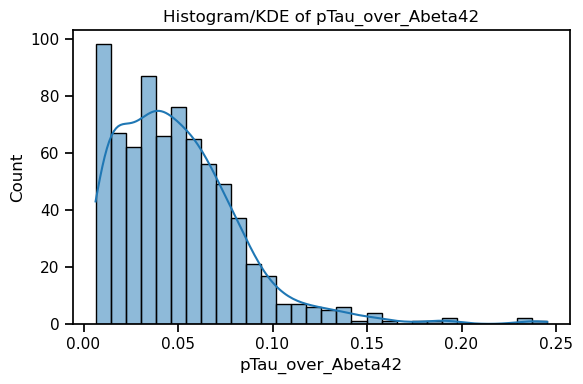

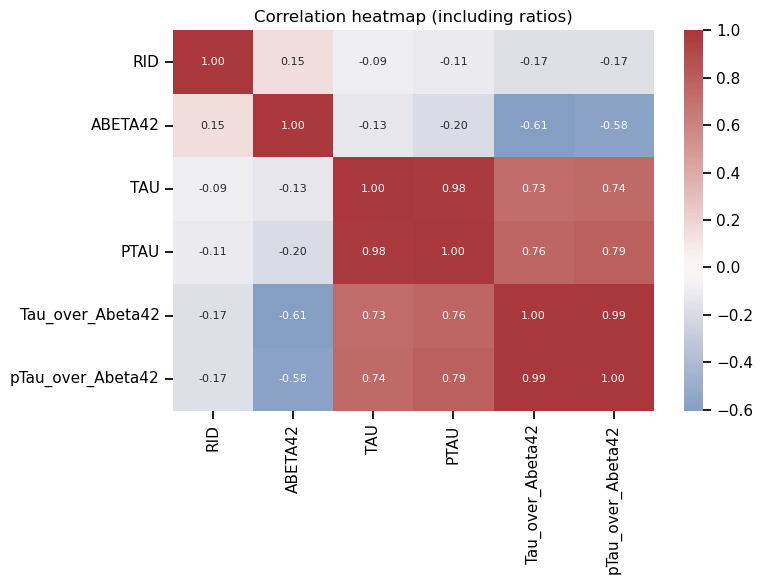

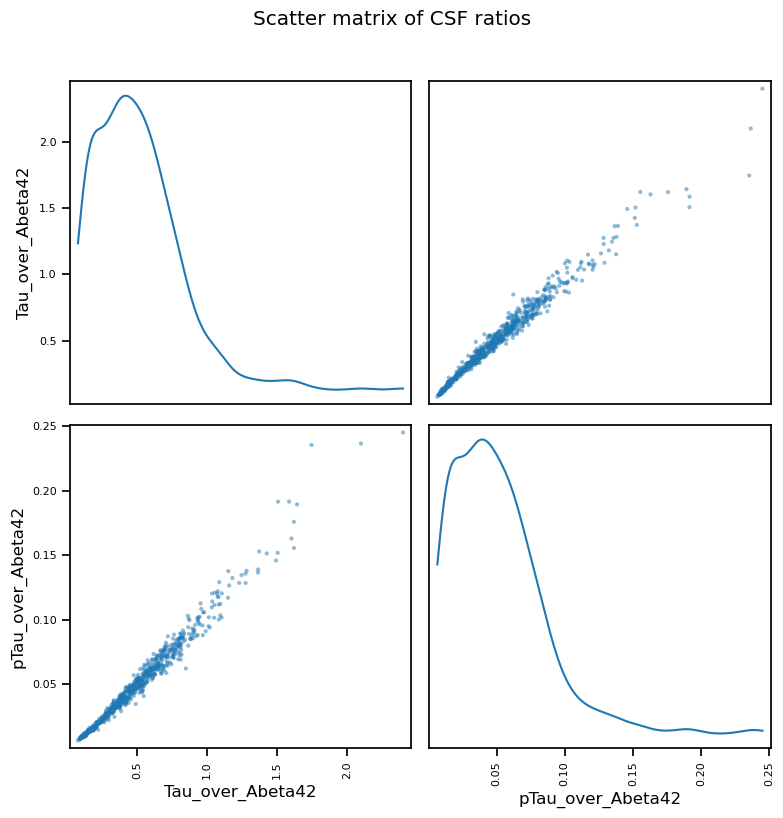

In [7]:
# EDA 
from pandas.plotting import scatter_matrix

#  Histogram/KDE of each ratio
ratio_cols = [c for c in ["Tau_over_Abeta42","pTau_over_Abeta42",''] if c in baseline.columns]
for c in ratio_cols:
    series = pd.to_numeric(baseline[c], errors="coerce").dropna()
    if series.empty:
        continue
    plt.figure(figsize=(6,4))
    if _HAS_SNS:
        sns.histplot(series, bins=30, kde=True)
        plt.title(f"Histogram/KDE of {c}")
    else:
        plt.hist(series, bins=30)
        plt.title(f"Histogram of {c}")
    plt.tight_layout(); plt.savefig(plots_dir / f"hist_kde_{c}.png", dpi=150)
    if SHOW_PLOTS: plt.show()
    plt.close()



    #  Correlation heatmap including ratios
num_df = baseline.select_dtypes(include=[np.number]).copy()
if not num_df.empty:
    corr = num_df.corr(numeric_only=True)
    plt.figure(figsize=(8,6))
    if _HAS_SNS:
        sns.heatmap(
            corr, 
            cmap="vlag", 
            center=0, 
            annot=True,      
            fmt=".2f",       
            annot_kws={"size":8}  
        )
        plt.title("Correlation heatmap (including ratios)")
    else:
        plt.imshow(corr, cmap="coolwarm", aspect="auto"); plt.colorbar(); plt.title("Correlation heatmap")
    plt.tight_layout(); plt.savefig(plots_dir / "corr_heatmap_csf.png", dpi=150)
    if SHOW_PLOTS: plt.show()
    plt.close()


# scatter-matrix of ratios 
if len(ratio_cols) >= 2:
    try:
        scatter_matrix(baseline[ratio_cols], figsize=(8,8), diagonal='kde')
        plt.suptitle("Scatter matrix of CSF ratios", y=1.02)
        plt.tight_layout(); plt.savefig(plots_dir / "scatter_matrix_ratios.png", dpi=150)
        if SHOW_PLOTS: plt.show()
        plt.close()
    except Exception as e:
        print("Scatter matrix skipped:", e)


In [8]:
# Imputation: MICE (numeric) + IQR clipping; 
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer, SimpleImputer

# copies
df_before = baseline.copy()
df_after  = baseline.copy()

# detect numeric vs categorical
obj_like = df_after.select_dtypes(include=['object','category']).columns.tolist()
num_like = df_after.select_dtypes(include=[np.number]).columns.tolist()

# Simple mode imputation 
obj_to_imp = [c for c in obj_like if df_after[c].isna().any()]
if obj_to_imp:
    mode_imp = SimpleImputer(strategy="most_frequent")
    df_after[obj_to_imp] = mode_imp.fit_transform(df_after[obj_to_imp])

# MICE for numeric columns
if num_like:
    mice = IterativeImputer(random_state=42, sample_posterior=False, max_iter=10, initial_strategy="median")
    df_after[num_like] = mice.fit_transform(df_after[num_like])

    # IQR clipping 
    for c in num_like:
        series = pd.to_numeric(df_after[c], errors="coerce")
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        if pd.isna(q1) or pd.isna(q3):
            continue
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        nonneg_hint = any(kw in c.lower() for kw in ["tau","beta","abeta","aβ","pg_ml","pgml","csf"]) \
                       or c.lower().endswith("_over_abeta42") or c.lower().endswith("_over_abeta40")
        clipped = series.clip(lower=lower, upper=upper)
        if nonneg_hint:
            clipped = clipped.clip(lower=0)
        df_after[c] = clipped

# Save outputs
baseline_path = outdir / "csf_baseline.xlsx"
imputed_path  = outdir / "csf_imputed.xlsx"

# baseline already saved earlier; re-save to ensure file exists
baseline.to_excel(baseline_path, index=False)
df_after.to_excel(imputed_path, index=False)

print("Saved baseline ->", baseline_path)
print("Saved imputed  ->", imputed_path)

# Summary
print("\n Imputation Summary (MICE numeric + IQR clip; mode for categorical) ")
print("Rows:", df_after.shape[0], "Cols:", df_after.shape[1])
print("Missing before:", int(df_before.isna().sum().sum()))
print("Missing after :", int(df_after.isna().sum().sum()))


Saved baseline -> /Users/madhurabn/Desktop/adni/data/processed/csf_baseline.xlsx
Saved imputed  -> /Users/madhurabn/Desktop/adni/data/processed/csf_imputed.xlsx

 Imputation Summary (MICE numeric + IQR clip; mode for categorical) 
Rows: 749 Cols: 8
Missing before: 15
Missing after : 0


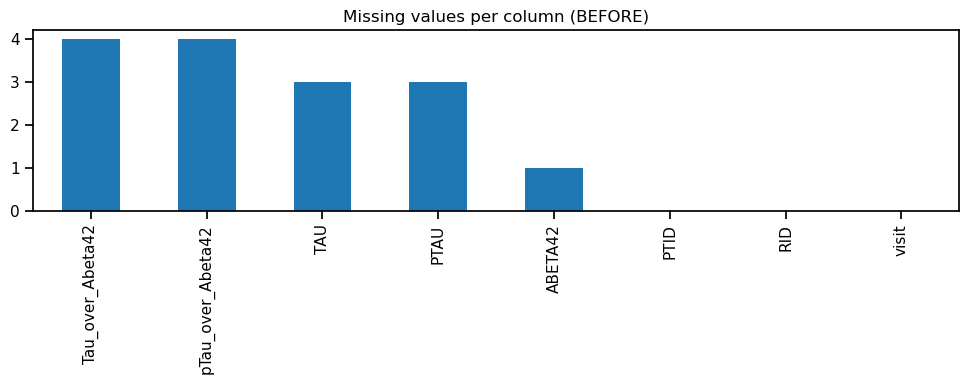

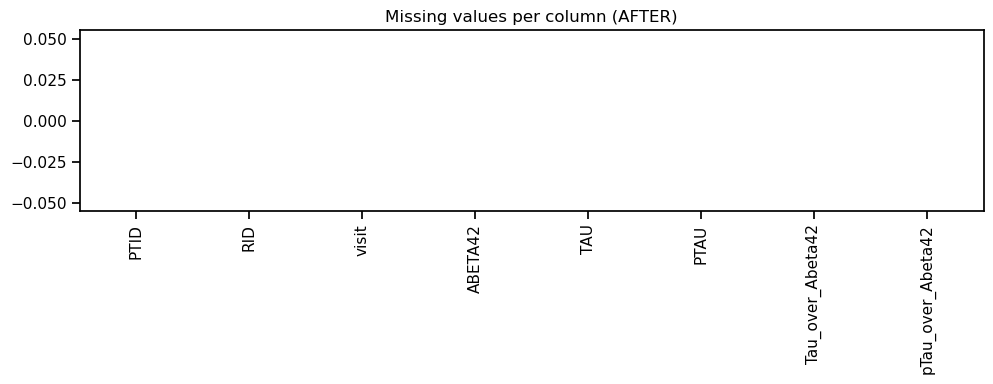

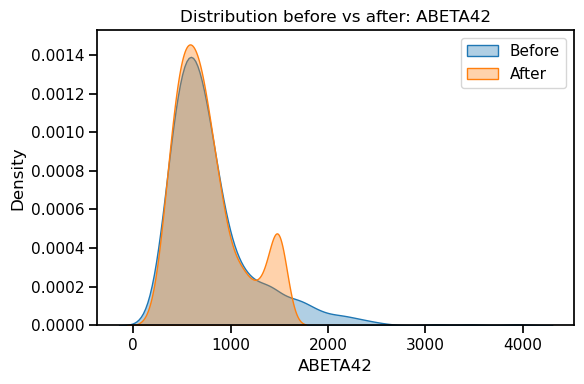

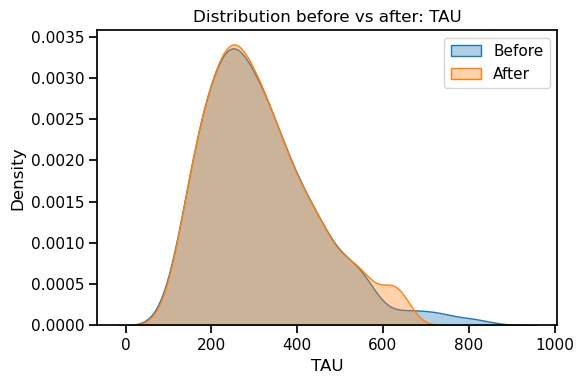

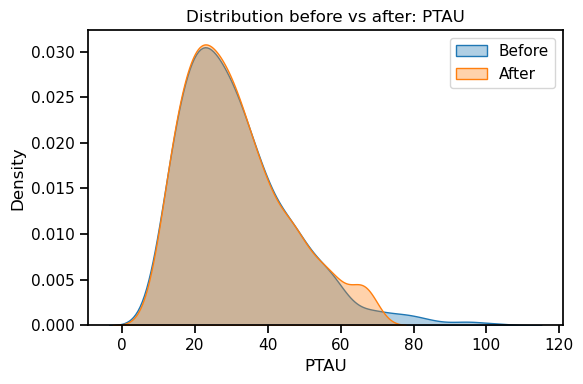

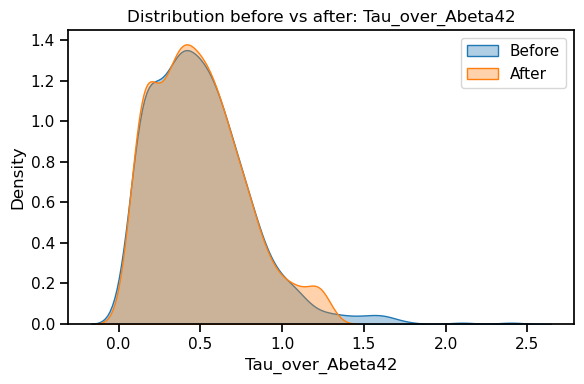

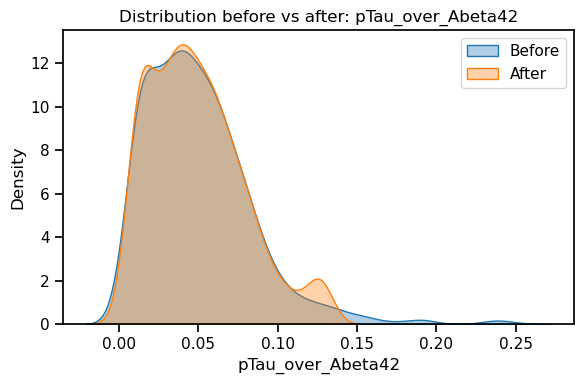

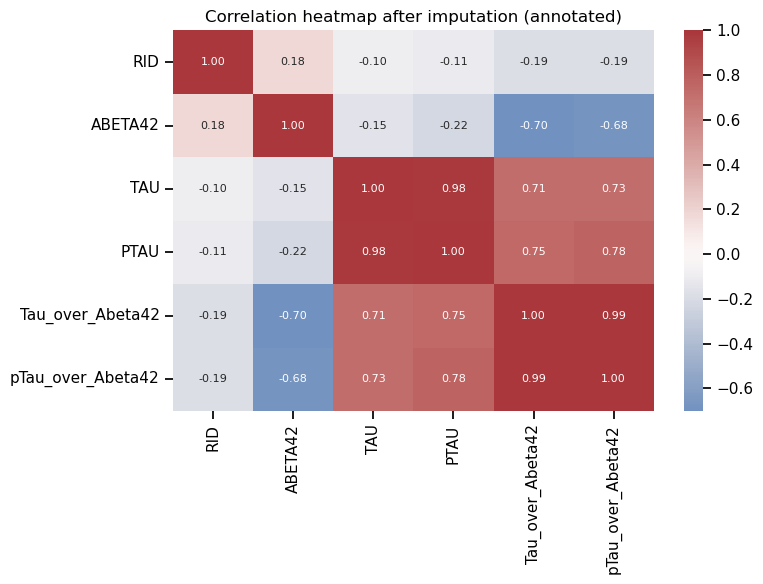

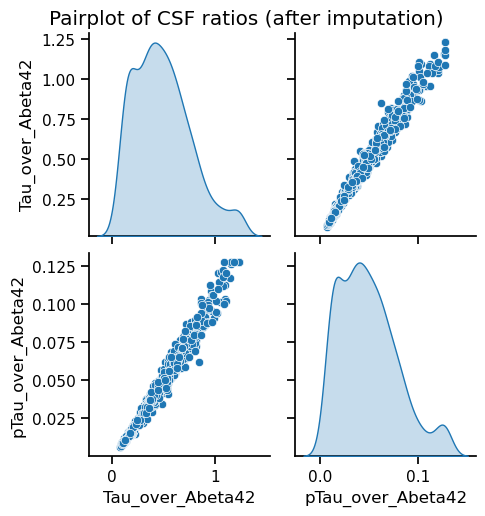

Post-imputation plots saved to: /Users/madhurabn/Desktop/adni/data/processed/plots/csf


In [9]:
#  Post-imputation plots 
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

try:
    import seaborn as sns
    _HAS_SNS = True
    sns.set_context("notebook")
except Exception:
    _HAS_SNS = False

# Safe filename 
def _safe(s: str) -> str:
    return re.sub(r'[\\/*?:"<>| ]+', "_", str(s))

# Ensure plot directory exists
plots_dir_csf = plots_dir if 'plots_dir' in globals() else Path("./data/processed/plots/csf")
Path(plots_dir_csf).mkdir(parents=True, exist_ok=True)

# Identify numeric columns of interest (biomarkers + ratios)
def _maybe_cols(df, names):
    return [c for c in names if c in df.columns]

ratio_cols = _maybe_cols(df_after, ["Tau_over_Abeta42", "pTau_over_Abeta42", ''])

# Try to auto-detect common CSF columns (numeric)
candidate_numeric = df_after.select_dtypes(include=[np.number]).columns.tolist()
likely_biomarkers = [c for c in candidate_numeric if any(k in c.lower() for k in ["tau","beta","abeta","aβ","pg_ml","pgml","csf"])]
key_cols = list(dict.fromkeys(likely_biomarkers + ratio_cols))  
if not key_cols:  
    key_cols = candidate_numeric[:6]

#  Missingness bar BEFORE/AFTER
for tag, df in [("before", baseline), ("after", df_after)]:
    plt.figure(figsize=(10,4))
    df.isna().sum().sort_values(ascending=False).plot(kind="bar", title=f"Missing values per column ({tag.upper()})")
    plt.tight_layout()
    outp = plots_dir_csf / f"missing_bar_{tag}.png"
    plt.savefig(outp, dpi=150)
    plt.show()

#  Distribution comparison (before vs after) for key CSF columns

for c in key_cols[:10]:  
    b = pd.to_numeric(baseline[c], errors="coerce")
    a = pd.to_numeric(df_after[c], errors="coerce")
    if b.notna().sum() == 0 and a.notna().sum() == 0:
        continue
    plt.figure(figsize=(6,4))
    if _HAS_SNS:
        if b.notna().sum() > 1:
            sns.kdeplot(b.dropna(), label="Before", fill=True, alpha=0.35)
        if a.notna().sum() > 1:
            sns.kdeplot(a.dropna(), label="After", fill=True, alpha=0.35)
    else:
        if b.notna().sum() > 0:
            plt.hist(b.dropna(), bins=30, alpha=0.5, label="Before", density=True)
        if a.notna().sum() > 0:
            plt.hist(a.dropna(), bins=30, alpha=0.5, label="After", density=True)
    plt.title(f"Distribution before vs after: {c}")
    plt.legend()
    plt.tight_layout()
    outp = plots_dir_csf / f"dist_compare_{_safe(c)}.png"
    plt.savefig(outp, dpi=150)
    plt.show()

# Correlation heatmap (AFTER imputation)
num_after = df_after.select_dtypes(include=[np.number])
if not num_after.empty:
    corr_after = num_after.corr(numeric_only=True)
    plt.figure(figsize=(max(8, 0.5 * len(corr_after.columns)), max(6, 0.5 * len(corr_after.columns))))
    if _HAS_SNS:
        sns.heatmap(
            corr_after,
            cmap="vlag",
            center=0,
            annot=True,   
            fmt=".2f",
            annot_kws={"size": 8}
        )
        plt.title("Correlation heatmap after imputation (annotated)")
    else:
        plt.imshow(corr_after, cmap="coolwarm", aspect="auto")
        plt.colorbar()
        plt.title("Correlation heatmap after imputation")
    plt.tight_layout()
    outp = plots_dir_csf / "corr_heatmap_after_imputation.png"
    plt.savefig(outp, dpi=150)
    plt.show()

# pairplot of ratios (AFTER) imputation
if _HAS_SNS and len(ratio_cols) >= 2:
    try:
        g = sns.pairplot(df_after[ratio_cols].dropna(), diag_kind="kde")
        g.fig.suptitle("Pairplot of CSF ratios (after imputation)", y=1.02)
        outp = plots_dir_csf / "pairplot_ratios_after.png"
        plt.savefig(outp, dpi=150)
        plt.show()
    except Exception as e:
        print("Pairplot skipped:", e)

print("Post-imputation plots saved to:", plots_dir_csf)
